In [55]:
import numpy as np
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


Aim: This code constructs an equivariant autoencoder for MNIST, designed to be equivariant under horizontal shifts. Three models are developed:

1. A linear autoencoder with rank 99,
2. A linear semi-equivariant autoencoder, created without enforcing the specific realization format,
3. A linear equivariant autoencoder.

For the theoretical foundation, refer to the paper "Geometry of Linear Neural Networks: Equivariance and Invariance under Permutation Groups" by Kathlén Kohn, Anna-Laura Sattelberger, and Vahid Shahverdi.
The preprint is available at arXiv:2309.13736.

In [23]:
# Constructing the permutation matrix P, and the realization basis Q.
first_row = np.zeros(28)
first_row[-1] = 1
circulant_matrix = np.zeros((28, 28))
for i in range(28):
    circulant_matrix[i, :] = np.roll(first_row, i)

block_diagonal_matrix = block_diag(*[circulant_matrix] * 28)
eigenvalues = np.linalg.eigvals(block_diagonal_matrix)

n = 28
def circulant_eigenvectors(n):
    dft_matrix = np.fft.fft(np.eye(n))
    eigenvectors = np.conjugate(dft_matrix.T)
    return eigenvectors

eigenvectors = circulant_eigenvectors(n)
def new_basis(eigenvectors):
    n = eigenvectors.shape[0]
    new_basis_vectors = np.zeros_like(eigenvectors, dtype=np.complex128)

    for j in range(1, n // 2 ):
        factor = 1 / ( np.sqrt(2*n))
        new_basis_vectors[:, 2*j-1] = (eigenvectors[:, j] + eigenvectors[:, -j]) * factor
        new_basis_vectors[:, 2*j] = (eigenvectors[:, j] - eigenvectors[:, -j]) * (-1j * factor)

    if n % 2 == 0:
        j = n // 2
        new_basis_vectors[:, -1] = (eigenvectors[:, j] + eigenvectors[:, -j]) / (2*np.sqrt(n))

    return new_basis_vectors

new_basis_vectors = new_basis(eigenvectors)
new_basis_vectors[:,0]= eigenvectors[:,0]/np.sqrt(n)
n_squared = n ** 2
matrix = np.zeros((n_squared, n_squared),dtype=np.complex128)

for i in range(n):
    matrix[i*n:i*n+n, i] = new_basis_vectors[:,0]
for j in range(13):    
    for i in range(n):
        matrix[i*n:i*n+n,2*i+n*(2*j+1)] = new_basis_vectors[:,2*j+1]
        matrix[i*n:i*n+n,2*i+n*(2*j+1)+1] = new_basis_vectors[:,2*j+2]
    
for i in range(n):
    matrix[i*n:i*n+n, n*(n-1)+i ] = new_basis_vectors[:,n-1]




In [3]:
# Loading MNIST dataset
mnist = fetch_openml("mnist_784")
X, y = mnist.data.astype('float32'), mnist.target.astype('int')
X, y = shuffle(X, y, random_state=42)

In [4]:
# Training a linear autoencoder with handwritten images (horizontally shifted up to 20 percent shifts)
from tensorflow.keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
datagen = ImageDataGenerator(height_shift_range=0.2, fill_mode='nearest')
x_train_shifted = []
for img in x_train:
    batch = img.reshape((1,) + img.shape)
    for batch_shifted in datagen.flow(batch, batch_size=1):
        x_train_shifted.append(batch_shifted[0, :, :, 0])
        break

x_train_shifted = np.array(x_train_shifted)
x_test_shifted = []
for img in x_test:
    batch = img.reshape((1,) + img.shape)
    for batch_shifted in datagen.flow(batch, batch_size=1):
        x_test_shifted.append(batch_shifted[0, :, :, 0])
        break

x_test_shifted = np.array(x_test_shifted)

# Flattening images
x_train_shifted_flat = x_train_shifted.reshape((len(x_train_shifted), np.prod(x_train_shifted.shape[1:])))
x_test_shifted_flat = x_test_shifted.reshape((len(x_test_shifted), np.prod(x_test_shifted.shape[1:])))
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Defining the linear autoencoder model with rank set to 99
input_img = Input(shape=(784,))
encoded = Dense(99, activation='linear', use_bias=False)(input_img)
decoded = Dense(784, activation='linear', use_bias=False)(encoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Training the autoencoder with the shifted dataset
autoencoder.fit(x_train_shifted_flat, x_train_shifted_flat, epochs=15, batch_size=256, shuffle=True, validation_data=(x_test_shifted_flat, x_test_shifted_flat))

# Encoding and decoding 10 random digits from the test set
np.random.seed(44)
random_indices = np.random.choice(x_test_shifted_flat.shape[0], 10, replace=False)
encoded_imgs = autoencoder.predict(x_test_shifted_flat[random_indices])


Epoch 1/15
235/235 [==============================] - 1s 4ms/step - loss: 0.0313 - val_loss: 0.0128
Epoch 2/15
235/235 [==============================] - 1s 4ms/step - loss: 0.0102 - val_loss: 0.0081
Epoch 3/15
235/235 [==============================] - 1s 4ms/step - loss: 0.0075 - val_loss: 0.0067
Epoch 4/15
235/235 [==============================] - 1s 4ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 5/15
235/235 [==============================] - 1s 4ms/step - loss: 0.0063 - val_loss: 0.0060
Epoch 6/15
235/235 [==============================] - 1s 4ms/step - loss: 0.0061 - val_loss: 0.0059
Epoch 7/15
235/235 [==============================] - 1s 4ms/step - loss: 0.0060 - val_loss: 0.0059
Epoch 8/15
235/235 [==============================] - 1s 4ms/step - loss: 0.0060 - val_loss: 0.0058
Epoch 9/15
235/235 [==============================] - 1s 4ms/step - loss: 0.0060 - val_loss: 0.0058
Epoch 10/15
235/235 [==============================] - 1s 4ms/step - loss: 0.0060 - val_loss: 0.0059

Encoder Weight Matrix Shape: (784, 99)
Decoder Weight Matrix Shape: (99, 784)


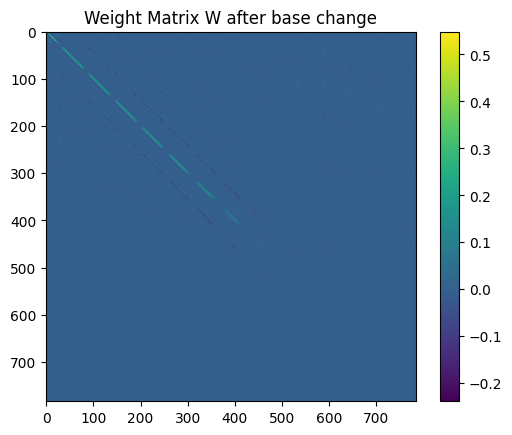

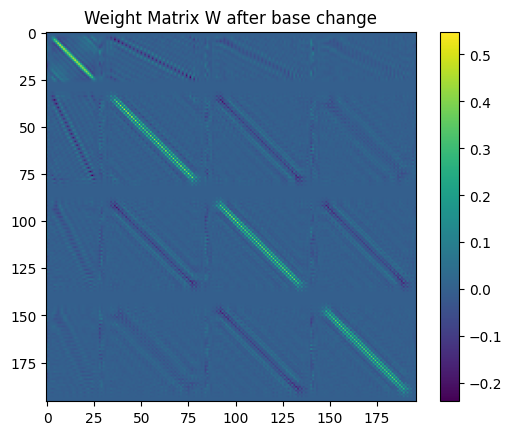

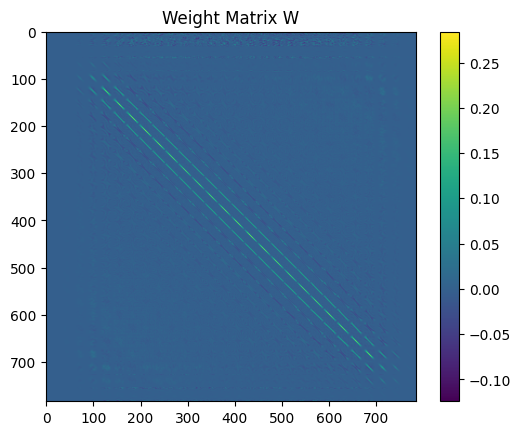

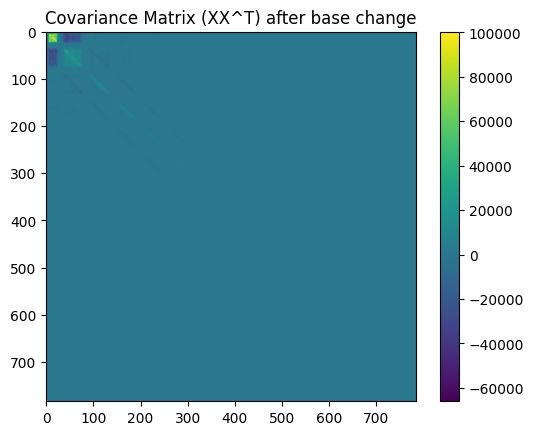

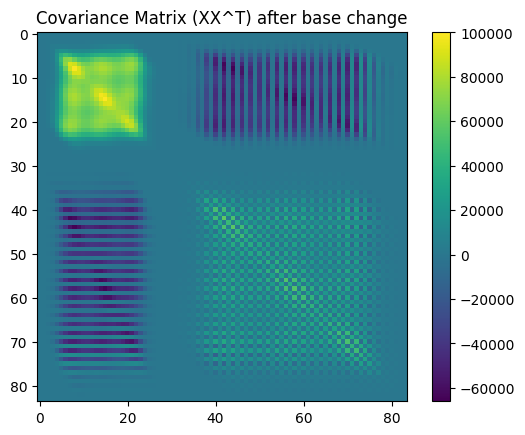

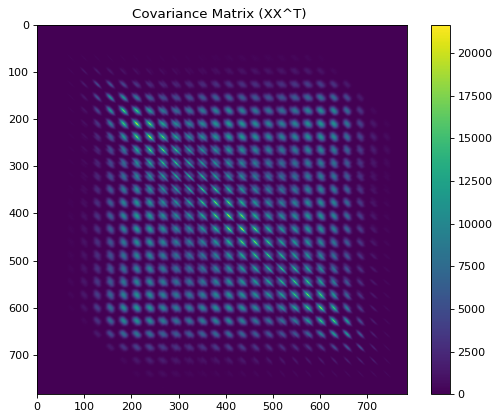

In [24]:
Q = matrix.real
# Getting the weights of the first dense layer (encoder)
encoder_weights = autoencoder.layers[1].get_weights()[0]
# Getting the weights of the second dense layer (decoder)
decoder_weights = autoencoder.layers[2].get_weights()[0]

print("Encoder Weight Matrix Shape:", encoder_weights.shape)
print("Decoder Weight Matrix Shape:", decoder_weights.shape)
WWs1 = encoder_weights @ decoder_weights
Ws1 = Q.T @ WWs1.T @ Q

plt.imshow(Ws1[0:,0:], cmap='viridis')
plt.title('Weight Matrix W after base change')
plt.colorbar()
plt.show()

plt.imshow(Ws1[0:196,0:196], cmap='viridis')
plt.title('Weight Matrix W after base change')
plt.colorbar()
plt.show()

plt.imshow(WWs1[0:,0:], cmap='viridis')
plt.title('Weight Matrix W')
plt.colorbar()
plt.show()

RR = x_train_shifted_flat.T @ x_train_shifted_flat
RR1 = Q.T @  RR.T@ Q
#print(np.linalg.matrix_rank(RR))

plt.imshow(RR1[0:,0:], cmap='viridis')
plt.title('Covariance Matrix (XX^T) after base change')
plt.colorbar()
plt.show()
plt.imshow(RR1[0:84,0:84], cmap='viridis')
plt.title('Covariance Matrix (XX^T) after base change')
plt.colorbar()
plt.show()

plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(RR, cmap='viridis')
plt.title('Covariance Matrix (XX^T) ')
plt.colorbar()
plt.show()


In [6]:
DD = x_train_shifted_flat @ Q

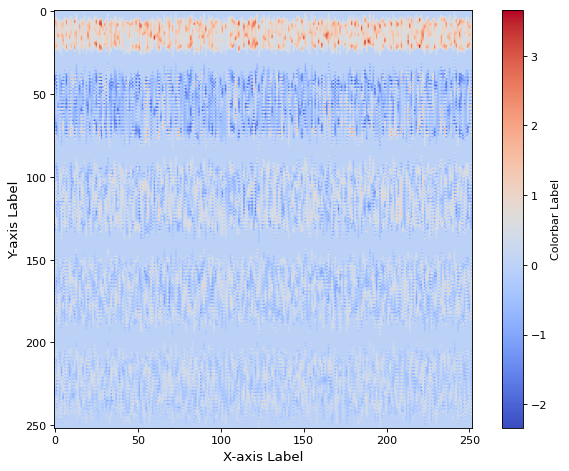

In [25]:
# Applying the base change for flattened data X
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(DD.T[0:252,0:252], cmap='coolwarm')  
plt.colorbar(label='Colorbar Label') 
plt.xlabel('X-axis Label', fontsize=12)  
plt.ylabel('Y-axis Label', fontsize=12) 
plt.tight_layout()  
plt.show()

Last row is the output of the non-equivariant autoencoder.


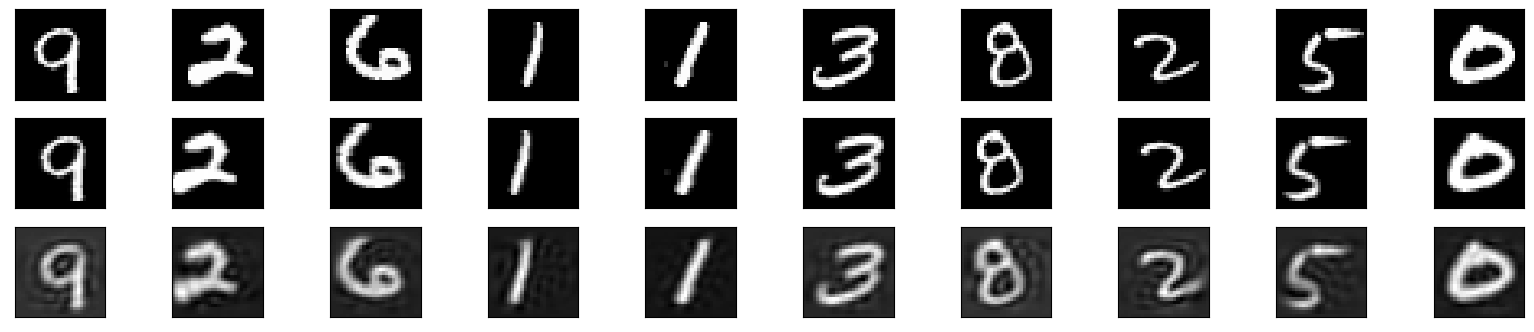

In [29]:
# Output of the trained linear autoencoder
plt.figure(figsize=(20, 4))
for i, index in enumerate(random_indices):
    
    ax = plt.subplot(3, 10, i + 1)
    
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, 10, i + 11)
    plt.imshow(x_test_shifted_flat[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #print(index)
    ax = plt.subplot(3, 10, i + 21)
    
    plt.imshow(encoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #error
    #print(np.mean(np.square(x_test_shifted_flat[index]-encoded_imgs[i])))
print('Last row is the output of the non-equivariant autoencoder.')
plt.show()



In [9]:
xtr_tot = DD
xte_tot = x_test_shifted_flat@Q

In [30]:
# Training a semi equivariant autoencoder (realization format has not been imposed) over 15 blocks. At different rank can be applied for each component.

xtr = xtr_tot[:,0:28]
xte = xte_tot[:,0:28]


input_img = Input(shape=(28,))
encoded = Dense(13, activation='linear', use_bias=False)(input_img)
decoded = Dense(28, activation='linear', use_bias=False)(encoded)
autoencoder0 = Model(input_img, decoded)
autoencoder0.compile(optimizer='adam', loss='mean_squared_error')
autoencoder0.fit(xtr, xtr, epochs=45, batch_size=256, shuffle=True, validation_data=(xte, xte))
np.random.seed(42)
encoded_imgs0 = autoencoder0.predict(xte[random_indices])
#####################################################################################
def encode_image(xtr_tot, xte_tot, rank=20, block_num=1, epochs=25, batch_size=256, random_seed=42):
    xtr = xtr_tot[:, 28 + 56 * (block_num - 1):28 + 56 * block_num]
    xte = xte_tot[:, 28 + 56 * (block_num - 1):28 + 56 * block_num]
    input_img = Input(shape=(56,))
    encoded = Dense(rank, activation='linear', use_bias=False)(input_img)
    decoded = Dense(56, activation='linear', use_bias=False)(encoded)
    autoencoderr = Model(input_img, decoded)
    autoencoderr.compile(optimizer='adam', loss='mean_squared_error')
    autoencoderr.fit(xtr, xtr, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(xte, xte))
    np.random.seed(random_seed) 
    encoded_imgsr = autoencoderr.predict(xte[random_indices])

    return encoded_imgsr, autoencoderr

encoded_imgs1, autoencoder1  = encode_image(xtr_tot, xte_tot, rank=20, block_num=1, epochs=25, batch_size=256)
encoded_imgs2, autoencoder2  = encode_image(xtr_tot, xte_tot, rank=18, block_num=2, epochs=25, batch_size=256)
encoded_imgs3, autoencoder3  = encode_image(xtr_tot, xte_tot, rank=16, block_num=3, epochs=25, batch_size=256)
encoded_imgs4, autoencoder4  = encode_image(xtr_tot, xte_tot, rank=14, block_num=4, epochs=25, batch_size=256)
encoded_imgs5, autoencoder5  = encode_image(xtr_tot, xte_tot, rank=10, block_num=5, epochs=25, batch_size=256)
encoded_imgs6, autoencoder6  = encode_image(xtr_tot, xte_tot, rank=6, block_num=6, epochs=25, batch_size=256)
encoded_imgs7, autoencoder7  = encode_image(xtr_tot, xte_tot, rank=2, block_num=7, epochs=25, batch_size=256)
encoded_imgs8, autoencoder8  = encode_image(xtr_tot, xte_tot, rank=0, block_num=8, epochs=2, batch_size=256)
encoded_imgs9, autoencoder9  = encode_image(xtr_tot, xte_tot, rank=0, block_num=9, epochs=2, batch_size=256)
encoded_imgs10, autoencoder10  = encode_image(xtr_tot, xte_tot, rank=0, block_num=10, epochs=2, batch_size=256)
encoded_imgs11, autoencoder11  = encode_image(xtr_tot, xte_tot, rank=0, block_num=11, epochs=2, batch_size=256)
encoded_imgs12, autoencoder12  = encode_image(xtr_tot, xte_tot, rank=0, block_num=12, epochs=2, batch_size=256)
encoded_imgs13, autoencoder13  = encode_image(xtr_tot, xte_tot, rank=0, block_num=13, epochs=2, batch_size=256)

#########################################################################
xtr = xtr_tot[:,756:]
xte = xte_tot[:,756:]
input_img = Input(shape=(28,))
encoded = Dense(0, activation='linear', use_bias=False)(input_img)
decoded = Dense(28, activation='linear', use_bias=False)(encoded)
autoencoder14 = Model(input_img, decoded)
autoencoder14.compile(optimizer='adam', loss='mean_squared_error')
autoencoder14.fit(xtr, xtr, epochs=2, batch_size=256, shuffle=True, validation_data=(xte, xte))
np.random.seed(42)
encoded_imgs14 = autoencoder14.predict(xte[random_indices])

Epoch 1/45
235/235 [==============================] - 1s 2ms/step - loss: 0.4147 - val_loss: 0.1373
Epoch 2/45
235/235 [==============================] - 0s 909us/step - loss: 0.1000 - val_loss: 0.0674
Epoch 3/45
235/235 [==============================] - 0s 874us/step - loss: 0.0505 - val_loss: 0.0363
Epoch 4/45
235/235 [==============================] - 0s 883us/step - loss: 0.0313 - val_loss: 0.0254
Epoch 5/45
235/235 [==============================] - 0s 1ms/step - loss: 0.0232 - val_loss: 0.0197
Epoch 6/45
235/235 [==============================] - 0s 1ms/step - loss: 0.0184 - val_loss: 0.0160
Epoch 7/45
235/235 [==============================] - 0s 1ms/step - loss: 0.0152 - val_loss: 0.0134
Epoch 8/45
235/235 [==============================] - 0s 1ms/step - loss: 0.0129 - val_loss: 0.0116
Epoch 9/45
235/235 [==============================] - 0s 1ms/step - loss: 0.0114 - val_loss: 0.0103
Epoch 10/45
235/235 [==============================] - 0s 1ms/step - loss: 0.0103 - val_loss: 

In [31]:
# Loop over each autoencoder model based on its number to construct block matrices WWi (weights)
for i in range(15): 
    autoencoderr = globals().get(f"autoencoder{i}")
    
    if autoencoderr: 
        encoder_weights = autoencoderr.layers[1].get_weights()[0]
        decoder_weights = autoencoderr.layers[2].get_weights()[0]
        WW = encoder_weights @ decoder_weights
        globals()[f"WW{i}"] = WW
    else:
        print(f"Warning: autoencoder{i} not found.")


<function matplotlib.pyplot.show(close=None, block=None)>

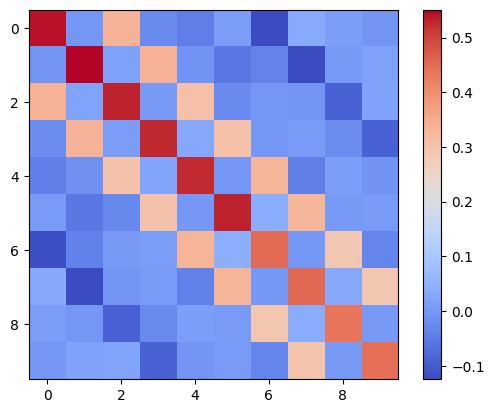

In [32]:
# Displaying the weight matrix of the semi equivariant linear autoencoder
from scipy.linalg import block_diag
block_diag_matrix = block_diag(WW0,WW1,WW2,WW3,WW4,WW5,WW6,WW7,WW8,WW9,WW10,WW11,WW12,WW13,WW14)
W_sol = Q @ block_diag_matrix.T @ Q.T
W_s = block_diag_matrix
plt.imshow(W_s[40:50,40:50], cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.show


error-semiequi_1: 0.00920087546307474  error-nonequi_1: 0.007793572265654802
error-semiequi_2: 0.007906883125309083  error-nonequi_2: 0.007671397179365158
error-semiequi_3: 0.011898919798377951  error-nonequi_3: 0.009325436316430569
error-semiequi_4: 0.00329054590504451  error-nonequi_4: 0.002592591568827629
error-semiequi_5: 0.002686143275052848  error-nonequi_5: 0.0014696319121867418
error-semiequi_6: 0.0064338113815938115  error-nonequi_6: 0.0049300468526780605
error-semiequi_7: 0.014018921326855211  error-nonequi_7: 0.011653241701424122
error-semiequi_8: 0.011268392565174246  error-nonequi_8: 0.007712443359196186
error-semiequi_9: 0.007921297377206695  error-nonequi_9: 0.007036897819489241
error-semiequi_10: 0.006376263196817253  error-nonequi_10: 0.004505335818976164


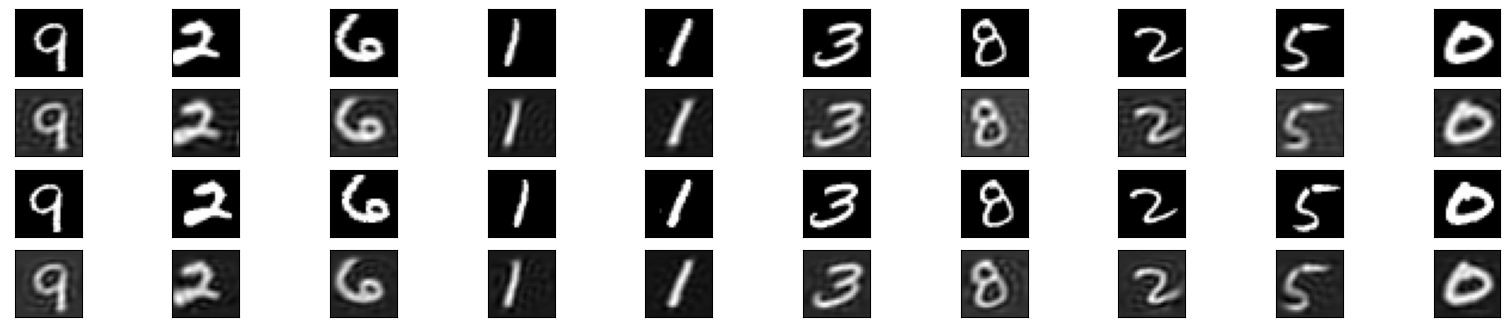

In [33]:
# Output of semi equivariant linear autoencoder with MSE.
import numpy as np
v = x_train_shifted_flat[10]
v =   W_sol @v  
plt.figure(figsize=(20, 4))
for i, index in enumerate(random_indices):
    
    ax = plt.subplot(4, 10, i + 1)
    plt.imshow(x_test_shifted_flat[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #print(index)
    v = x_test_shifted_flat[index]
    v =   W_sol @v 
    ax = plt.subplot(4, 10, i + 11)
    plt.imshow(v.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(4, 10, i + 21)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(4, 10, i + 31)
    plt.imshow(encoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #print(np.mean(np.square(x_test_shifted_flat[index]-v)))
    #print(np.mean(np.square(x_test_shifted_flat[index]-encoded_imgs[i])))
    result_a = np.mean(np.square(x_test_shifted_flat[index] - v))
    result_b = np.mean(np.square(x_test_shifted_flat[index] - encoded_imgs[i]))
    # Print the results next to each other
    print(f'error-semiequi_{i+1}: {result_a}  error-nonequi_{i+1}: {result_b}')
plt.show()
# Second row of images: semi equivariant linear autoencoder
# Last row of images: non-equivariant linear autoencoder

In [37]:
# Error compution for the semi equivariant and non-equivariant network.
import numpy as np
result_equi=[]
result_nonequi=[]
for i in range(300):
    random_indices1111 = np.random.choice(x_test_shifted_flat.shape[0], 300, replace=False)
    v = x_test_shifted_flat[random_indices1111[i]]
    v =  W_sol @v 
    result_equi.append(np.mean(np.square(x_test_shifted_flat[random_indices1111[i]] - v)))
    encoded_imgs1111 = autoencoder.predict(x_test_shifted_flat[random_indices1111])
    result_nonequi.append(np.mean(np.square(x_test_shifted_flat[random_indices1111[i]] - encoded_imgs1111[i])))

print(f"Error for the semi-equi autoencoder: {np.mean(result_equi)}")
print(f"Error for the autoencoder: {np.mean(result_nonequi)}")


10/10 [==============================] - 0s 2ms/step
Error for the semi-equi autoencoder: 0.007703107325005931
Error for the autoencoder: 0.005697142332792282


In [38]:
# Applyig the realization format to semi equivariant network to make it fully equivariant under horizontal shift (see the paper).
def process_matrix(WW, rank):
    WWW = WW.copy()
    for i in range(28):
        for j in range(28):
            WWW[2*i, 2*j] = (WW[2*i, 2*j] + WW[2*i+1, 2*j+1]) / 2
            WWW[2*i+1, 2*j+1] = (WW[2*i, 2*j] + WW[2*i+1, 2*j+1]) / 2
            WWW[2*i, 2*j+1] = -(WW[2*i+1, 2*j] - WW[2*i, 2*j+1]) / 2
            WWW[2*i+1, 2*j] = (WW[2*i+1, 2*j] - WW[2*i, 2*j+1]) / 2
    W_shrink = WWW[::2, :]

    U, S, Vt = np.linalg.svd(W_shrink, full_matrices=False)
    U_ranked = U[:, :rank]
    S_ranked = np.diag(S[:rank])
    Vt_ranked = Vt[:rank, :]
    W_ranked = np.dot(U_ranked, np.dot(S_ranked, Vt_ranked))

    W_expand = np.zeros((56, 56))
    for i in range(56):
        for j in range(56):
            if i % 2 == 0:
                W_expand[i, j] = W_ranked[int(i / 2), j]
            else:
                if j % 2 == 0:
                    W_expand[i, j] = -W_ranked[int(i / 2), j+1]
                else:
                    W_expand[i, j] = W_ranked[int(i / 2), j-1]

    return W_expand
# Up to the seventh Fourier mode is considered.
W1_expand = process_matrix(WW1, rank=10)
W2_expand = process_matrix(WW2, rank=9)
W3_expand = process_matrix(WW3, rank=8)
W4_expand = process_matrix(WW4, rank=7)
W5_expand = process_matrix(WW5, rank=5)
W6_expand = process_matrix(WW6, rank=3)
W7_expand = process_matrix(WW7, rank=1)




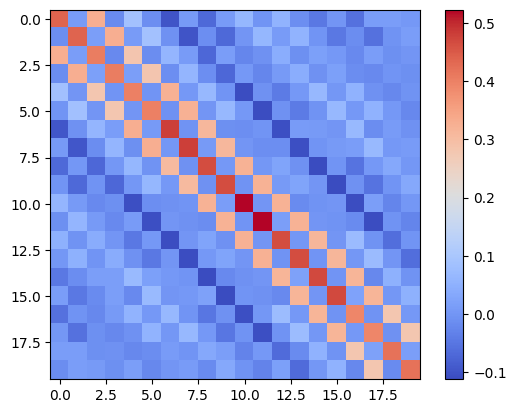

In [39]:
# A realization block.
plt.imshow(W1_expand[20:40, 20:40], cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

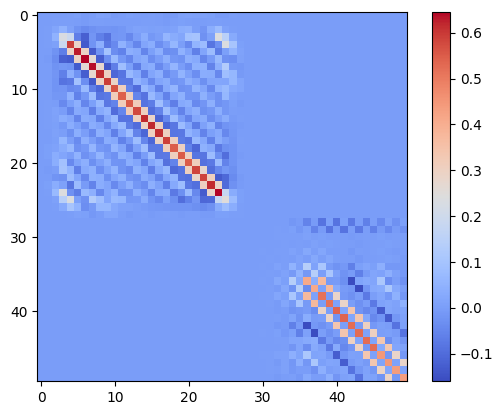

In [40]:
# Displaying the weight matrix for the trained linear autoencoder which is equivariant under horizental shift
block_diag_matrix_equi = block_diag(WW0,W1_expand,W2_expand,W3_expand,W4_expand,W5_expand,W6_expand,W7_expand,WW8,WW9,WW10,WW11,WW12,WW13,WW14)
W_sol_equi = Q @ block_diag_matrix_equi.T @ Q.T
W_s_equi = block_diag_matrix_equi
plt.imshow(W_s_equi[0:50,0:50], cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.show


image error equi_1: 0.010140847340113104 image error nonequi_1: 0.007793572265654802
image error equi_2: 0.008304069404441004 image error nonequi_2: 0.007671397179365158
image error equi_3: 0.012439747528996096 image error nonequi_3: 0.009325436316430569
image error equi_4: 0.0037121705213254293 image error nonequi_4: 0.002592591568827629
image error equi_5: 0.0029102650348801977 image error nonequi_5: 0.0014696319121867418
image error equi_6: 0.006914757342172366 image error nonequi_6: 0.0049300468526780605
image error equi_7: 0.0153122160101377 image error nonequi_7: 0.011653241701424122
image error equi_8: 0.012282259441973954 image error nonequi_8: 0.007712443359196186
image error equi_9: 0.008412279070223995 image error nonequi_9: 0.007036897819489241
image error equi_10: 0.0068793267134309105 image error nonequi_10: 0.004505335818976164


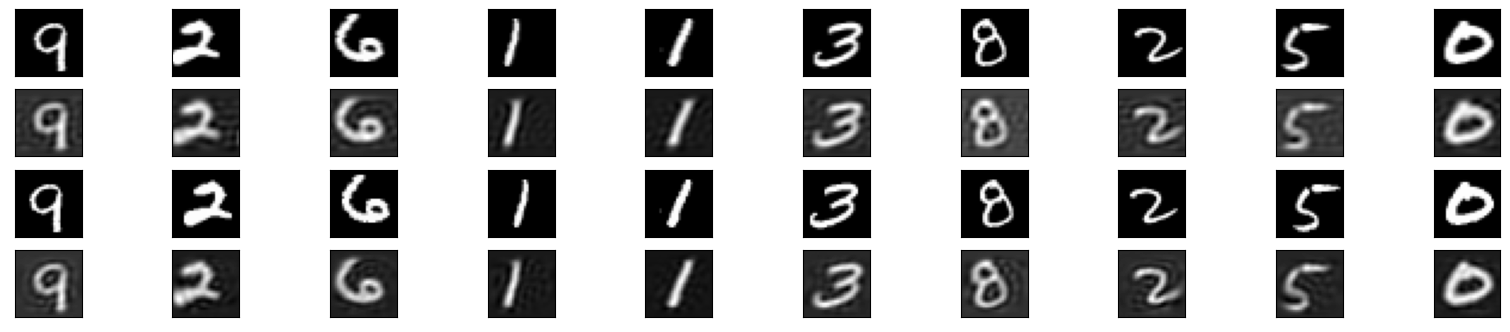

In [43]:
# Output of the linear equivariant autoencoder and linear autoencoder.
import numpy as np
v = x_train_shifted_flat[10]
v =   W_sol_equi @v  
np.random.seed(44)
random_indices = np.random.choice(x_test_shifted_flat.shape[0], 10, replace=False)

plt.figure(figsize=(20, 4))
for i, index in enumerate(random_indices):
    
    ax = plt.subplot(4, 10, i + 1)
    plt.imshow(x_test_shifted_flat[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #print(index)
    v = x_test_shifted_flat[index]
    v =   W_sol_equi @v 
    ax = plt.subplot(4, 10, i + 11)
    plt.imshow(v.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(4, 10, i + 21)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(4, 10, i + 31)
    plt.imshow(encoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #print(np.mean(np.square(x_test_shifted_flat[index]-v)))
    #print(np.mean(np.square(x_test_shifted_flat[index]-encoded_imgs[i])))
    result_a = np.mean(np.square(x_test_shifted_flat[index] - v))
    result_b = np.mean(np.square(x_test_shifted_flat[index] - encoded_imgs[i]))
    print(f'image error equi_{i+1}: {result_a} image error nonequi_{i+1}: {result_b}')
plt.show()
# Error for fully equivariant and non-equivariant autoencdoer is displayed.
# In the picture, the first row is randomly shifted data, second row is the output of the equivariant linear autoencoder
# The third row is the original data without random shift and the fourth row is the output of the non-equivariant linear autoencoder.

In [44]:
# Error computation for the linear equivariant autoencdoer
import numpy as np
result_equi=[]
result_nonequi=[]
for i in range(300):
    
    random_indices1111 = np.random.choice(x_test_shifted_flat.shape[0], 300, replace=False)
    v = x_test_shifted_flat[random_indices1111[i]]
    v =  W_sol_equi @v 
    result_equi.append(np.mean(np.square(x_test_shifted_flat[random_indices1111[i]] - v)))
    encoded_imgs1111 = autoencoder.predict(x_test_shifted_flat[random_indices1111])
    result_nonequi.append(np.mean(np.square(x_test_shifted_flat[random_indices1111[i]] - encoded_imgs1111[i])))


10/10 [==============================] - 0s 2ms/step


In [45]:
# The final error for equivariant and non-equvariant linear autoencoder
print(np.mean(result_equi))
print(np.mean(result_nonequi))

0.008319698413421636
0.005911063


In [46]:
# Computation of the number of different equivariant architectures using dynamic programming
def count_solutions(y, n, constraints):
    m = len(y)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    dp[0][0] = 1

    for i in range(1, m + 1):
        for j in range(n + 1):
            k = 0
            while k * y[i - 1] <= j and k <= constraints[1]:
                dp[i][j] += dp[i - 1][j - k * y[i - 1]]
                k += 1
    return dp[m][n]

def main():
    y = [1,2,2,2,2,2,2,2,2,2,2,2,2,2,1] 
    n = 99
    constraints = (0, 28)  
    result = count_solutions(y, n, constraints)
    print(f"Number of real irreducible components: {result}")

if __name__ == "__main__":
    main()


Number of real irreducible components: 72425986088826
